In [29]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [210]:
N_ = 10 # number of tokens in a sequence
d_ = 100 # dimension of token embedding space

def positional_encoder(d, N, R = 1000):
    """
    See:
        https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
        https://en.wikipedia.org/wiki/Transformer_(machine_learning_model). 
    R should be much larger than d. Wikipedia calls R -> N.
    """
    r = np.power(R,2/d)
    ts = torch.range(0,N-1).repeat(int(d/2),1)
    ks = torch.transpose(torch.range(0,d/2-1).repeat(N,1), 0,1)
    thetas = ts/np.power(r,ks)
    return torch.stack(
        (torch.sin(thetas),torch.cos(thetas)), dim=1).view(d,N)

In [224]:
class AttnHead(nn.Module):
    def __init__(self, N, M, Mp):
        super(self).__init__()
        self.WQ = nn.Linear(in_features = M, out_features = M, bias = False)
        self.WK = nn.Linear(in_features = M, out_features = M, bias = False)
        self.WV = nn.Linear(in_features = M, out_features = Mp, bias = False)
        
    def create_mask():
        """
        NxN mask that is true for i <= j
        """
        return (torch.range(1,N).repeat(N,1) <= torch.range(1,N).repeat(N,1).transpose(0,1)) 
 
    def dot_product_attn(Q, K, V):
        """
        Let 
            N be the number of tokens in the sequence 
            M = d, M' positive integers
        Q should be NxM
        K should be NxM 
        V should be NXMp
        """
        d = K.shape[-1]
        N = Q.shape[0]
        return torch.matmul(
            torch.nn.Softmax(1)(
                torch.matmul(Q, torch.transpose(K,0,1)) / np.sqrt(d)
            ) * create_mask(N), 
            V) 
        
    def forward(self, x):
        x = x + positional_encoder(M, N)
        Q, K, V = self.WQ(x), self.WK(x), self.WV(x)
        return dot_product_attn(Q,K,V)

In [212]:
d = 7
Q = torch.normal(mean = torch.zeros(2,3), std = torch.ones(2,3))
K = torch.normal(mean = torch.zeros(2,3), std = torch.ones(2,3))
V = torch.normal(mean = torch.zeros(2,3), std = torch.ones(2,3))

/var/folders/07/65yfr7y95sd5nhnx51849p580000gn/T/ipykernel_32969/1907381693.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  return (torch.range(1,N).repeat(N,1) <= torch.range(1,N).repeat(N,1).transpose(0,1))


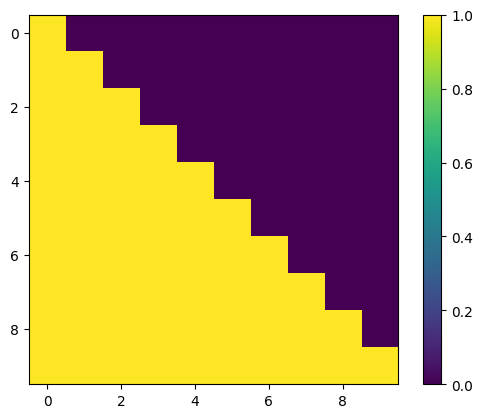

In [221]:
plt.imshow(create_mask(10))
plt.colorbar()

In [171]:
torch.nn.Softmax(1)(torch.matmul(Q, torch.transpose(K,0,1)) / np.sqrt(d)) 

tensor([[0.2795, 0.7205],
        [0.1499, 0.8501]])

In [176]:
torch.matmul(Q, torch.transpose(K,0,1))

tensor([[ 0.6683,  3.1739],
        [-2.4948,  2.0967]])

In [26]:
Q.shape[-1]

3

In [174]:
from functools import reduce
output = reduce(torch.matmul, [Q, torch.transpose(K,0,1)])

In [175]:
output

tensor([[ 0.6683,  3.1739],
        [-2.4948,  2.0967]])

In [177]:
V

tensor([[-0.2845, -0.9007,  1.0853],
        [ 0.5305, -1.2809,  0.1880]])